In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle

movielibrary = pickle.load(open("With_IMDB.p", "rb"))

# Retrieve information from Box Office Mojo weekly table

Reads in values from Box Office Mojo weekly table into a dataframe, and saves that dataframe as Weeklies_BoxOfficeMojo_df.p. 
Name was used as an index as I originally drew from the movies each year; it later was found to be inaccurate to the actual name of the movie, but perfectly functional as an indexing tool. 

In [3]:
cols = ["REAL name", "Name","Date", "Rank", "Weekly", "%LW", "Theaters", "Change", "Avg", "To Date", "Week", "Estimated"]


table = []
movies_to_skip = pickle.load(open("Movies to skip.p", "rb"))
for movie in list(movielibrary.keys()):
    if movie not in movies_to_skip:
        page = BeautifulSoup(movielibrary[movie]["Domestic Weekly"], "lxml")
        main_table = page.find("table")
        title = page.find("h1", class_="a-size-extra-large").text
        if main_table!=None:        
            for row in main_table.find_all("tr")[1:]:
                newrow = [title, movie]
                
                for item in row.find_all("td"):
                    newrow.append(item.text)
                table.append(newrow)
        else:
            movies_to_skip.add(movie)
        
weeklies_df= pd.DataFrame(data = table, columns =cols)
pickle.dump(movies_to_skip, open("Movies to skip.p", "wb"))

Beetlejuice2018 Re-release
Elf2018 Re-release
The Shining2017 Re-release
The Dark Knight2018 Re-release
The Wizard of Oz2018 Re-release
Harry Potter and the Sorcerer's Stone2018 Re-release
Harry Potter and the Chamber of Secrets2018 Re-release
Harry Potter and the Prisoner of Azkaban2018 Re-release
Harry Potter and the Goblet of Fire2018 Re-release
Harry Potter and the Deathly Hallows: Part 22018 Re-release
Harry Potter and the Deathly Hallows: Part 12018 Re-release
Harry Potter and the Order of the Phoenix2018 Re-release
Harry Potter and the Half-Blood Prince2018 Re-release
Madame
Time Freak
Furlough
Billionaire Boys Club
Moscow Never Sleeps
Fathom Premieres 6 Below: Miracle on the Mountain
Generation Iron 2
National Bird
Best of Enemies: Buckley vs. Vidal
Digging for Fire
Olvidados2015 Re-release
Top Spin
Godzilla2014 Re-release
Penton: The John Penton Story
The Retrieval
Missionary
Jackpot2014 Re-release
Grand départ
Hannah Arendt
The Lost Medallion: The Adventures of Billy Stone
Lo

In [9]:
weeklies_df[weeklies_df["Name"]!=weeklies_df["REAL name"]]

,REAL name,Name,Date,Rank,Weekly,%LW,Theaters,Change,Avg,To Date,Week,Estimated
1939,Arctic,Arctic2019 Re-release,Feb 1-7,44,"$66,908",-,4,-,"$16,727","$66,908",1,false
1940,Arctic,Arctic2019 Re-release,Feb 8-14,48,"$121,676",+81.9%,15,+11,"$8,111","$188,584",2,false
1941,Arctic,Arctic2019 Re-release,Feb 15-21,35,"$365,221",+200.2%,15,-,"$24,348","$553,805",3,false
1942,Arctic,Arctic2019 Re-release,Feb 22-28,24,"$713,704",+95.4%,257,+242,"$2,777","$1,267,509",4,false
1943,Arctic,Arctic2019 Re-release,Mar 1-7,27,"$535,988",-24.9%,268,+11,"$1,999","$1,803,496",5,false
...,...,...,...,...,...,...,...,...,...,...,...,...
40758,Syrup,Remnants,Jun 14-20,112,$285,-24.6%,1,-,$285,$663,2,false
40759,Hammer of the Gods,Billy and Buddy,Jul 5-11,104,$191,-,2,-,$95,$191,1,false
40760,Hammer of the Gods,Billy and Buddy,Jul 12-18,115,$450,+135.6%,2,-,$225,$641,2,false
40761,Triumph of the Wall,I Spit on Your Grave 2,May 31-Jun 6,115,$476,-,1,-,$476,$476,1,false


In [10]:
df_fixed_lines = weeklies_df.copy()

df_fixed_lines["Avg"] = df_fixed_lines["Avg"].apply(lambda x: int(x.replace(",", "").replace("$", "").replace("-", "1")))
df_fixed_lines["Week"] = df_fixed_lines["Week"].apply(lambda x: int(x.replace("-", "1")))
for_max_value = df_fixed_lines.rename(columns={"Avg": "Peak"}).groupby(["Name"])[["Name", "Peak"]].max().reset_index(drop=True).merge(df_fixed_lines)
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"In Theaters"}).groupby("Name")["In Theaters"].max().reset_index())
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"Weeks of Data"}).groupby("Name")["Weeks of Data"].count().reset_index())
for_max_value

,Name,Peak,REAL name,Date,Rank,Weekly,%LW,Theaters,Change,Avg,To Date,Week,Estimated,In Theaters,Weeks of Data
0,'71,6392,Beyond the Mask,Apr 3-9,19,"$441,755",-,86,-,5136,"$441,754",1,false,20,20
1,'71,6392,Beyond the Mask,Apr 10-16,30,"$140,385",-68.2%,39,-47,3599,"$582,139",2,false,20,20
2,'71,6392,Beyond the Mask,Apr 17-23,37,"$70,291",-49.9%,21,-18,3347,"$652,431",3,false,20,20
3,'71,6392,Beyond the Mask,Apr 24-30,57,"$31,634",-55%,5,-16,6326,"$684,065",4,false,20,20
4,'71,6392,Beyond the Mask,May 1-7,57,"$19,178",-39.4%,3,-2,6392,"$703,243",5,false,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40758,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 17-23,100,"$2,451",-45.7%,1,-,2451,"$6,962",2,false,4,4
40759,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 24-30,68,"$13,721",+459.8%,6,+5,2286,"$20,683",3,false,4,4
40760,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 31-Jun 6,118,$325,-97.6%,1,-5,325,"$21,008",4,false,4,4
40761,Évolution,1027,Sudden Fear,Aug 12-18,61,"$18,498",-,18,-,1027,"$18,498",1,false,2,2


In [11]:
# # A number of values I examined using as metrics for decay rate. Deprecated. 

# for_max_value["Decay to-date"] = for_max_value["Avg"]/for_max_value["Peak"]
# for_max_value["Log Decay"] = np.log(for_max_value["Decay to-date"])
# for_max_value["Log Week"] = np.log(for_max_value["Week"])
# for_max_value["Log Decay as weekly"] = for_max_value["Log Decay"]/(for_max_value["Week"])
# for_max_value["Decay inverse"] = (for_max_value["Decay to-date"])*(for_max_value["Week"])
# for_max_value["Complete Data"]= (for_max_value["In Theaters"]==for_max_value["Weeks of Data"])

/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
import time
import datetime

def to_week_number(item):
    item=item.split("-")[0]
    month, day= item.split(" ")
    if len(day)==1:
        day = " "+day
    return datetime.datetime.strptime(month+day, "%b%d").isocalendar()[1]
for_max_value["Week_of_Year"] = for_max_value["Date"].apply(to_week_number)

In [13]:
import matplotlib.pyplot as plt

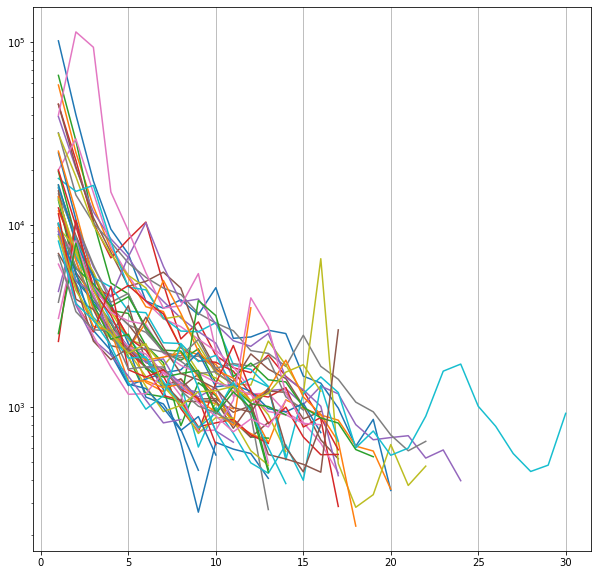

In [16]:
#Plotting: Decay rate as a function of time, as compared to the peak box office per-theater.
plt.figure(figsize=(10, 10))
plt.yscale("log")
for name in list(movielibrary.keys())[0:50]:
    movieselector = for_max_value[for_max_value["Name"]==name]
    plt.plot(movieselector["Week"], movieselector["Avg"])
plt.grid(axis="x")

In [17]:
pickle.dump(for_max_value, open("Weeklies_BoxOfficeMojo_df.p", "wb"))

# Retrieve information from Box Office Mojo summary page

Functions similarly to the IMDB reader. Extracts key metrics into "BoxOfficeMojo_df.p".

In [3]:
summary_values = []
cols = ["Name", "Budget", "MPAA", "Genres", "Domestic Opening", "Running Time"]
import re

set_of_MPAAs= set({})
set_of_genres = set({})
movies_to_skip = pickle.load(open("Movies to skip.p", "rb"))
for movie in list(movielibrary.keys()):
    if "BOM Summary" in movielibrary[movie]:
        main_table = BeautifulSoup(movielibrary[movie]["BOM Summary"], "lxml").find(class_="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile")
        if main_table!=None:        
            name = movie
            divs = main_table.find_all("div")
            
            budget_ = main_table.find(text="Budget")
            if budget_ !=None:
                budget = budget_.findNext().text
            else:
                budget = None
            
            mpaa_ = main_table.find(text="MPAA")
            if mpaa_ != None: 
                mpaa = mpaa_.findNext().text
                set_of_MPAAs.add(mpaa)
            else: 
                mpaa=None
                
            genres_ = main_table.find(text="Genres")
            if genres_ !=None:
                genres = set(re.split(" |\n", genres_.findNext().text))
                set_of_genres.update(genres)
            else:
                genres = set({})
                
                
            runtime_ = main_table.find(text="Running Time")
            if runtime_ !=None:
                runtime = runtime_.findNext().text
            else:
                runtime = None
            
            opening_ = main_table.find(text="Opening")
            if opening_ !=None:
                opening = opening.findNext().text
            else:
                opening = None
            
            summary_values.append([name, budget, mpaa, genres, opening, runtime])
            
        else:
            print(movie)
            movies_to_skip.add(movie)
    else:
        print(movie)
        movies_to_skip.add(movie)
movie_attributes= pd.DataFrame(data=summary_values, columns=cols)
print(set_of_MPAAs)
print(set_of_genres)
pickle.dump(movies_to_skip, open("Movies to skip.p", "wb"))

Friendsgiving Day #1
Friendsgiving Day #2
Doctor Who: Logopolis
Fritz Lang's Indian Epic2019 re-release
Jim Henson's Holiday Special with Fraggle Rock and Emmet Otter
The Walking Dead: Wrath/The Walking Dead/Fear the Walking Dead: What's Your Story?/Fear the Walking Dead2018 NCM Fathom Event
Dragon Ball Z: Bardock - The Father of Goku/Dragon Ball Z: Fusion Reborn
Sailor Moon R: The Movie: The Promise of the Rose/Sailor Moon S: The Movie - Hearts in IceDouble Bill
Cobra Kai Premiere Event feat. The Karate Kid2018 NCM Fathom Event
Jumanji/Jumanji: Welcome to the Jungle2018 NCM Fathom Event
A Bread Factory, Part One/A Bread Factory, Part Two
Disney Junior HalloVeen Party!
Marius/Fanny/César
Billy Lynn's Long Halftime Walk
Old Fashioned
Son of Saul
Badlapur
Tap World
Some Velvet Morning
{'G', 'PG', 'NC-17', 'Not Rated', 'PG-13', 'M/PG', 'TV-PG', 'R'}
{'', 'Thriller', 'Film-Noir', 'Biography', 'Animation', 'Crime', 'Documentary', 'Adventure', 'Sport', 'Reality-TV', 'Mystery', 'News', 'Music

In [4]:
list_of_MPAAs = list(set_of_MPAAs)
list_of_MPAAs.sort()
list_of_genres = list(set_of_genres)
list_of_genres.sort()

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

In [6]:
#USE: MultiLabelBinarizer
mlb = MultiLabelBinarizer()

genres = list(list(zip(*summary_values))[3])
vals = mlb.fit_transform(genres)
cols = mlb.classes_
movie_genres = pd.DataFrame(data=vals, columns=cols)

In [7]:
movies_and_genres = movie_attributes.reset_index().merge(movie_genres.reset_index())

In [8]:
for rating in list_of_MPAAs:
    movies_and_genres[rating] = movies_and_genres["MPAA"]==rating

In [12]:
movies_and_genres[movies_and_genres["M/PG"]==1]

,index,Name,Budget,MPAA,Genres,Domestic Opening,Running Time,,Action,Adult,...,War,Western,G,M/PG,NC-17,Not Rated,PG,PG-13,R,TV-PG
1096,1096,Bullitt2018 Re-release,None,M/PG,"{Action, , Thriller, Crime}",None,1 hr 54 min,1,1,0,...,0,0,False,True,False,False,False,False,False,False


Strip out second date, convert to datetime

Two options:

-Find diff target variable, different question? 

-Present as data exploration, exploration of this target variable as a linearly modeled problem; what did and didn't work. Why the problem can't be modeled linearly, what I learned about linear modeling. Ideally, presentation is something that makes me look good. Difference: Explaining failure as a finding, vs. just saying that I failed. 

In [9]:
pickle.dump(movies_and_genres, open("BoxOfficeMojo_df.p", "wb"))